# Functions

In [11]:
import numpy as np
from mpmath import mp
from tqdm import tqdm
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from utils import save_exponents_csv
from renormalization_hp import *

mp.dps = 100  # Set desired precision

plus_configs = [
    ([1,1,1], lambda J1, J2: 2*J1 + J2, mp.mpf('3')),
    ([1,1,-1], lambda J1, J2: -J2, mp.mpf('1')),
    ([1,-1,1], lambda J1, J2: -2*J1 + J2, mp.mpf('1')),
    ([-1,1,1], lambda J1, J2: -J2, mp.mpf('1'))
]

minus_configs = [
    ([-1,-1,-1], lambda J1, J2: 2*J1 + J2, mp.mpf('-3')),
    ([-1,-1,1], lambda J1, J2: -J2, mp.mpf('-1')),
    ([-1,1,-1], lambda J1, J2: -2*J1 + J2, mp.mpf('-1')),
    ([1,-1,-1], lambda J1, J2: -J2, mp.mpf('-1'))
]

def get_J(d, J0, n):
    if d <= 0:
        return mp.mpf(0)
    return mp.mpf(J0) / mp.power(mp.mpf(d), mp.mpf(n))

def mp_logsumexp(lst):
    if not lst:
        return mp.ninf
    a_max = max(lst)
    if mp.isinf(a_max):
        return a_max
    tmp = sum(mp.exp(a - a_max) for a in lst)
    return a_max + mp.log(tmp)

def compute_R_logs(start, J_func, h):
    J1 = J_func(1)
    J2 = J_func(2)
    distances = [(iL, iR, (start + iR) - (1 + iL)) for iL in range(3) for iR in range(3)]

    def get_totals(left_confs, right_confs):
        totals = []
        for spinsL, El_func, sumL in left_confs:
            El = El_func(J1, J2)
            for spinsR, Er_func, sumR in right_confs:
                Er = Er_func(J1, J2)
                Eint = mp.mpf('0')
                for iL, iR, d in distances:
                    Eint += mp.mpf(spinsL[iL] * spinsR[iR]) * J_func(d)
                total = El + Er + Eint + h * (sumL + sumR)
                totals.append(total)
        return totals

    totals_pp = get_totals(plus_configs, plus_configs)
    totals_pm = get_totals(plus_configs, minus_configs)
    totals_mp = get_totals(minus_configs, plus_configs)
    totals_mm = get_totals(minus_configs, minus_configs)

    log_R_pp = mp_logsumexp(totals_pp)
    log_R_pm = mp_logsumexp(totals_pm)
    log_R_mp = mp_logsumexp(totals_mp)
    log_R_mm = mp_logsumexp(totals_mm)

    return log_R_pp, log_R_pm, log_R_mp, log_R_mm

def compute_J_prime_func(start, J_func, h):
    log_pp, log_pm, log_mp, log_mm = compute_R_logs(start, J_func, h)
    if mp.isinf(log_pm) or mp.isinf(log_mp):
        return mp.inf
    ln_arg = log_pp + log_mm - log_pm - log_mp
    return mp.mpf('0.25') * ln_arg

def compute_H_prime_func(start, J_func, h): # start = 4 for r'=1
    log_pp, _, _, log_mm = compute_R_logs(start, J_func, h)
    ln_arg = log_pp - log_mm
    return mp.mpf('0.25') * ln_arg

def generate_rg_flow(J0, n, max_k, num_steps):
    J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
    rs = list(range(1, max_k + 1))
    initial_Js = [J_func(r) for r in rs]
    all_Js = [initial_Js]
    all_J_funcs = [J_func]
    h = mp.mpf(0)
    for step in range(1, num_steps + 1):
        Jps = []
        for r in rs:
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func, h)
            Jps.append(Jp)
        all_Js.append(Jps)
        J_dict = {r: Jps[r-1] for r in rs}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        all_J_funcs.append(J_func)
    return all_Js, all_J_funcs

def construct_recursion_matrix(J0, n, max_k, num_steps, matrix_size=5, epsilon=1e-6):
    all_Js, _ = generate_rg_flow(J0, n, max_k, num_steps)
    if len(all_Js) < 2:
        raise ValueError("Need at least 2 steps for derivatives")

    # Extract first matrix_size from last two steps
    J_k_minus_1 = all_Js[-2][:matrix_size]  # list of mp.mpf, truncated
    J_k = all_Js[-1][:matrix_size]  # list of mp.mpf, truncated

    M = matrix_size  # Size of matrix
    jac = np.zeros((M, M))

    # Define compute_T truncated to M
    def compute_T(J_vec_mp):
        J_dict = {r+1: J_vec_mp[r] for r in range(M)}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        J_prime = []
        h = mp.mpf(0)  # h=0
        for r in range(1, M+1):
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func, h)
            J_prime.append(Jp)
        return J_prime

    epsilon_mp = mp.mpf(epsilon)

    J_k_minus_1_float = np.array([float(j) for j in J_k_minus_1])
    J_k_float = np.array([float(j) for j in J_k])

    for s in range(M):
        J_pert_mp = [j for j in J_k_minus_1]  # copy list of mp
        J_pert_mp[s] += epsilon_mp
        T_pert_mp = compute_T(J_pert_mp)
        T_pert_float = np.array([float(j) for j in T_pert_mp])
        jac[:, s] = (T_pert_float - J_k_float) / float(epsilon)

    return jac

def find_J_c(n, max_k=1000, tol=1e-6, J_low=1e-10, J_high=3.0):
    if n <= 0 or n >= 2:
        raise ValueError("n must be between 0 and 2, excluding the edges.")

    start_track = 3
    max_steps = 5
    tol = mp.mpf(tol)
    J_low = mp.mpf(J_low)
    J_high = mp.mpf(J_high)
    rs = list(range(1, max_k + 1))

    def compute_flow(J0):
        J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
        all_Js = [[J_func(r) for r in rs]]
        h = mp.mpf(0)
        for step in range(1, max_steps + 1):
            Jps = [compute_J_prime_func(3 * r + 1, J_func, h) for r in rs]
            all_Js.append(Jps)
            if step >= start_track:
                J_r2_current = Jps[1]
                J_r2_previous = all_Js[-2][1]
                if J_r2_current > J_r2_previous:
                    return all_Js, True  # Growing (ferromagnetic)
                if J_r2_current < J_r2_previous:
                    return all_Js, False  # Decaying (paramagnetic)
            J_dict = {r: Jps[r-1] for r in rs}
            J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        # Fallback
        J_r2_initial = all_Js[0][1]
        J_r2_final = all_Js[-1][1]
        return all_Js, J_r2_final > J_r2_initial

    iter_count = 0
    while J_high - J_low > tol and iter_count < 100:
        iter_count += 1
        J_mid = (J_low + J_high) / 2
        _, is_growing = compute_flow(J_mid)
        if is_growing:
            J_high = J_mid  # Growing: search lower half
        else:
            J_low = J_mid  # Decaying: search upper half
    return (J_low + J_high) / 2

def compute_dH_prime_dH(J0, n, max_k, num_steps, h_small='1e-30'):
    """
    Compute the derivative ∂H'/∂H at low temperature using finite differences.
    
    Parameters:
    J0 (float): Initial coupling strength (high for low temperature)
    n (float): Power-law exponent
    max_k (int): Maximum distance for couplings
    num_steps (int): Number of RG steps to reach fixed point
    h_small (str or float): Small magnetic field perturbation
    
    Returns:
    float: Approximate ∂H'/∂H
    """
    # Generate RG flow to get fixed-point couplings
    all_Js, _ = generate_rg_flow(J0, n, max_k, num_steps)
    J_fixed = all_Js[-1]  # Take the last step as fixed point
    J_func_fixed = lambda d: J_fixed[d-1] if 1 <= d <= max_k else mp.mpf(0)
    
    # Compute H' with small perturbation h_small
    h_small = mp.mpf(h_small)
    H_prime = compute_H_prime_func(4, J_func_fixed, h_small)  # r'=1, start=4
    dH_prime_dH = H_prime / h_small
    
    return float(dH_prime_dH)

def compute_magnetization(J0, n, max_k, num_steps, h_small=mp.mpf('1e-30'), b=3, d=1, M_k=1.0):
    all_Js, all_J_funcs = generate_rg_flow(J0, n, max_k, num_steps)
    product = mp.mpf('1')
    for i in range(num_steps):
        J_func_i = all_J_funcs[i]
        H_prime = compute_H_prime_func(4, J_func_i, h_small)
        dH_dH_i = H_prime / h_small
        product *= dH_dH_i
    M_0 = float(product / mp.power(mp.mpf(b), mp.mpf(num_steps * d)) * M_k)
    return M_0

# Magnetization

## RG flow method

100%|██████████| 10/10 [16:02<00:00, 96.27s/it]


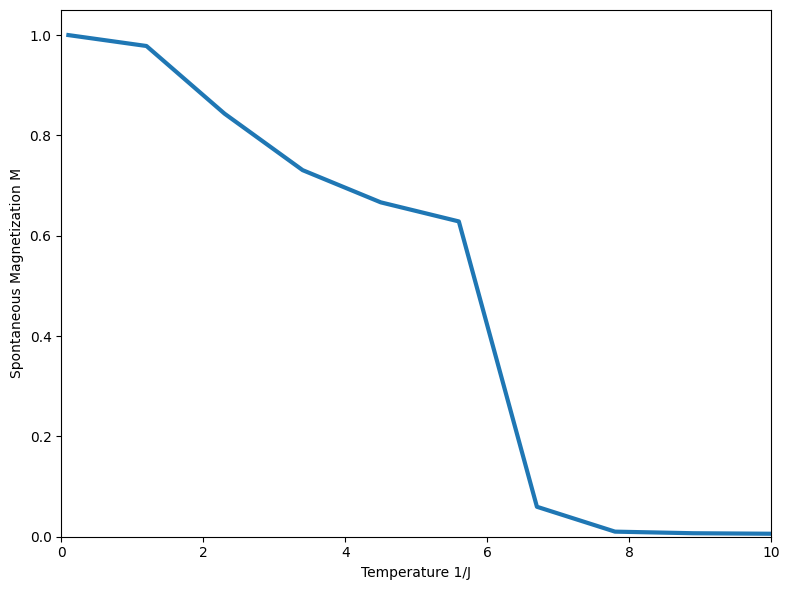

In [14]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parameters
n = 1
max_k = 3**8
num_steps = 8
h_small = mp.mpf('1e-30')
b = 3
d = 1
M_k = 1.0

def is_ordered(J0, n, max_k, num_steps):
    all_Js, _ = generate_rg_flow(J0, n, max_k, num_steps)
    J_final = all_Js[-1][0]
    J_initial = all_Js[0][0]
    return float(J_final) > float(J_initial)

# Compute M for T values
T_values = np.linspace(0.1, 10, 10)
M_values = []

for i, T in enumerate(tqdm(T_values)):
    J0 = 1.0 / T
    #if is_ordered(J0, n, max_k, num_steps):
    M = compute_magnetization(J0, n, max_k, num_steps, h_small, b, d, M_k)
    #else:
    #    M = 0.0
    M_values.append(M)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T_values, M_values, linewidth=3, label=f'n={n}')
#ax.axvline(x=Tc, color='r', linestyle='--', alpha=0.5, label=f'$T_c$≈{Tc:.2f}')
ax.set_xlabel('Temperature 1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_xlim(0, max(T_values))
ax.set_ylim(0, 1.05)
#ax.legend()
ax.grid(False)
plt.tight_layout()
#plt.savefig(f'../figures/magnetization_n{n}.png')
plt.show()

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T_values, M_values, linewidth=3, label=f'n={n}')
#ax.axvline(x=Tc, color='r', linestyle='--', alpha=0.5, label=f'$T_c$≈{Tc:.2f}')
ax.set_xlabel('Temperature 1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_xlim(0, max(T_values))
ax.set_ylim(0, 1.05)
#ax.legend()
ax.grid(False)
plt.tight_layout()
#plt.savefig(f'../figures/magnetization_n{n}.png')
plt.show()

In [ ]:
x = np.array([ 0.01      ,  0.53578947,  1.06157895,  1.58736842,  2.11315789,
        2.63894737,  3.16473684,  3.69052632,  4.21631579,  4.74210526,
        5.26789474,  5.79368421,  6.31947368,  6.84526316,  7.37105263,
        7.89684211,  8.42263158,  8.94842105,  9.47421053, 10.        , 5.        , 5.22222222, 5.44444444, 5.66666667, 5.88888889,
       6.11111111, 6.33333333, 6.55555556, 6.77777778, 7.,5.8       , 5.87777778, 5.95555556, 6.03333333, 6.11111111,
       6.18888889, 6.26666667, 6.34444444, 6.42222222, 6.5          ])

y = np.array([1.0,
 0.9998580432694417,
 0.9875047771382623,
 0.9383223522082523,
 0.868018713393121,
 0.8022631849569118,
 0.7499215771985464,
 0.7101226934469516,
 0.6798790664195917,
 0.65654609868668,
 0.6381924719190402,
 0.6111576805669414,
 0.21365756645702508,
 0.05261720051178325,
 0.027325498516533812,
 0.019698240381895316,
 0.01628679023116995,
 0.014396920486058075,
 0.013205447169645577,
 0.012387424917935016,
 0.6470166623913275,
 0.6396265710453933,
 0.632892372928469,
 0.6252165966640828,
 0.5817610843249523,
 0.40620585499856554,
 0.20395027177854186,
 0.10172672609474627,
 0.05983394422843034,
 0.04105337170422092,
 0.6098820619070321,
 0.5864856753634312,
 0.5447500338735437,
 0.4827357390266239,
 0.40620585499856554,
 0.32663246653513567,
 0.25485082708439466,
 0.19649723726591797,
 0.1520890993163269,
 0.11943486516322652])

x = np.sort(x)
y = np.sort(y)[::-1]

In [ ]:
# Save both arrays to a single .npz file
np.savez('../data/magnetization.npz', array1=T_values, array2=M_values)

In [ ]:
# Load the arrays from the .npz file
with np.load('../data/magnetization.npz') as data:
    #T_values = data['array1']
    #M_values = data['array2']
    x = data['array1']
    y = data['array2']

In [ ]:
# Find critical temperature
Tc = 1 / find_J_c(n, max_k=1000, tol=1e-6, J_low=1e-10, J_high=3.0
print(f"$T_c$ = {Tc}")

In [ ]:
import matplotlib.pyplot as plt
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, marker='', linewidth=3, label=f'n={n}')
#ax.plot(T_values, M_values, marker='o', linestyle='', linewidth=3, color='r', label=f'n={n}')
ax.axvline(x=Tc, color='r', linestyle='--', alpha=0.5, label=f'$T_c$≈{float(Tc):.2f}')
ax.set_xlabel('Temperature 1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_xlim(0, 10)
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(False)
plt.tight_layout()
#plt.savefig(f'../figures/magnetization.png')
plt.show()

## Scaling approximation method - Beta fitting

Critical Tc for n=1.2: 4.036316515553326
beta = 0.02748948443733226


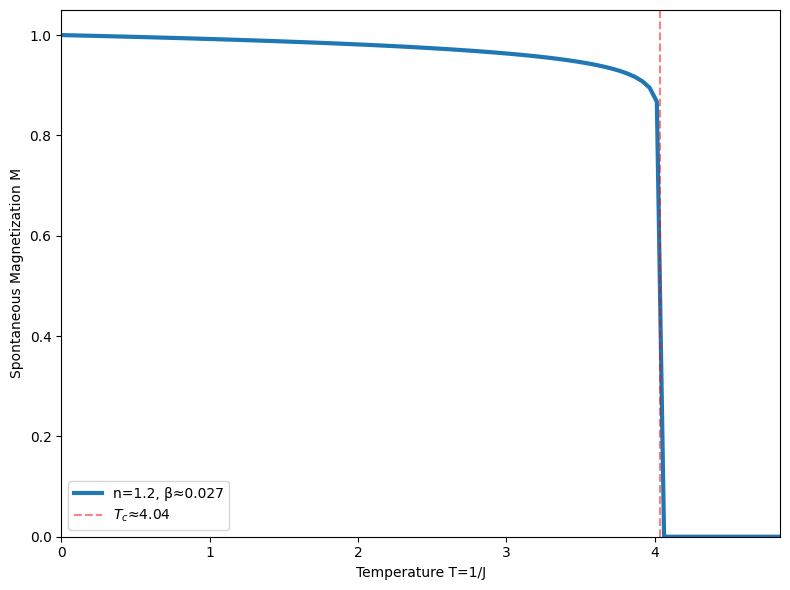

In [16]:
# Parameters
n = 1.2  # Fixed power-law exponent
max_k = 1000
num_steps = 4
matrix_size = 5
b = 3.0  # Rescaling factor

# Find J_c and T_c
Jc = find_J_c(n, max_k=max_k, tol=1e-6, J_low=1e-10, J_high=3.0)
Tc = 1 / float(Jc)
print(f"Critical Tc for n={n}: {Tc}")

# Compute recursion matrix at J_c
M_matrix = construct_recursion_matrix(float(Jc), n, max_k, num_steps, matrix_size=matrix_size)

# Eigenvalues for y_T
eigenvalues = np.linalg.eigvals(M_matrix)
eigenvalues = sorted(eigenvalues, key=abs, reverse=True)
lambda_t = eigenvalues[0]
yT = np.log(abs(lambda_t)) / np.log(b) if abs(lambda_t) > 0 else 0

# Compute y_H
all_Js, _ = generate_rg_flow(float(Jc), n, max_k, num_steps)
J_fixed = all_Js[-1]
J_func_fixed = lambda d: J_fixed[d-1] if 1 <= d <= max_k else mp.mpf(0)
h_small = mp.mpf('1e-30')
H_prime = compute_H_prime_func(4, J_func_fixed, h_small)
dyh = H_prime / h_small
yH = float(mp.log(dyh) / mp.log(mp.mpf('3')))

# Compute beta
beta = (1 - yH) / yT if yT != 0 else np.inf
print(f"beta = {beta}")

# Plot M vs T
T_values = np.linspace(0.01, 1.2 * Tc, 100)  # From near 0 to above Tc
M_values = np.zeros_like(T_values)
for i, T in enumerate(T_values):
    if T < Tc:
        M_values[i] = (1 - T / Tc)**beta

# Create 2D plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T_values, M_values, linewidth=3, label=f'n={n}, β≈{beta:.3f}')
ax.axvline(x=Tc, color='r', linestyle='--', alpha=0.5, label=f'$T_c$≈{Tc:.2f}')
ax.set_xlabel('Temperature T=1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_xlim(0, max(T_values))
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(False)
plt.tight_layout()
#plt.savefig(f'../figures/magnetization_n{n}.png')
plt.show()

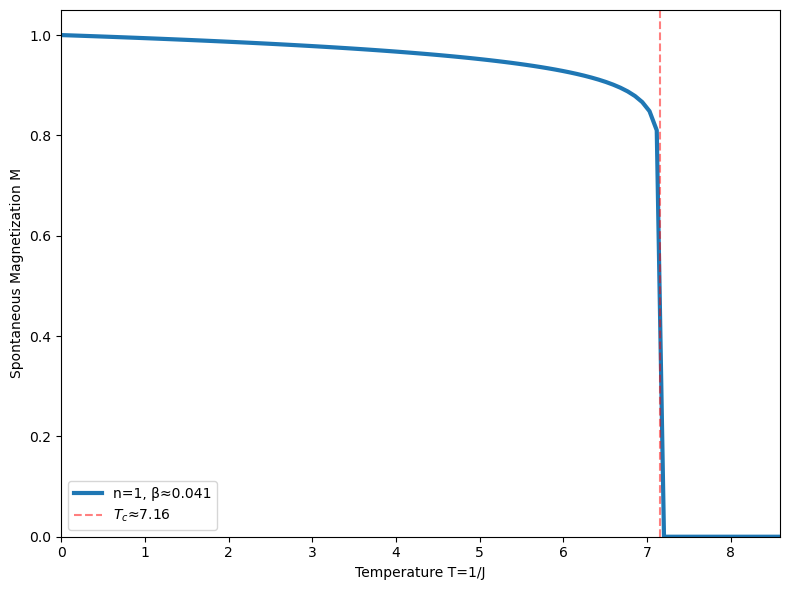

In [105]:
# Create 2D plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T_values, M_values, linewidth=3, label=f'n={n}, β≈{beta:.3f}')
ax.axvline(x=Tc, color='r', linestyle='--', alpha=0.5, label=f'$T_c$≈{Tc:.2f}')
ax.set_xlabel('Temperature T=1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_xlim(0, max(T_values))
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(False)
plt.tight_layout()
#plt.savefig(f'../figures/magnetization_n{n}.png')
plt.show()

### Multiple a values

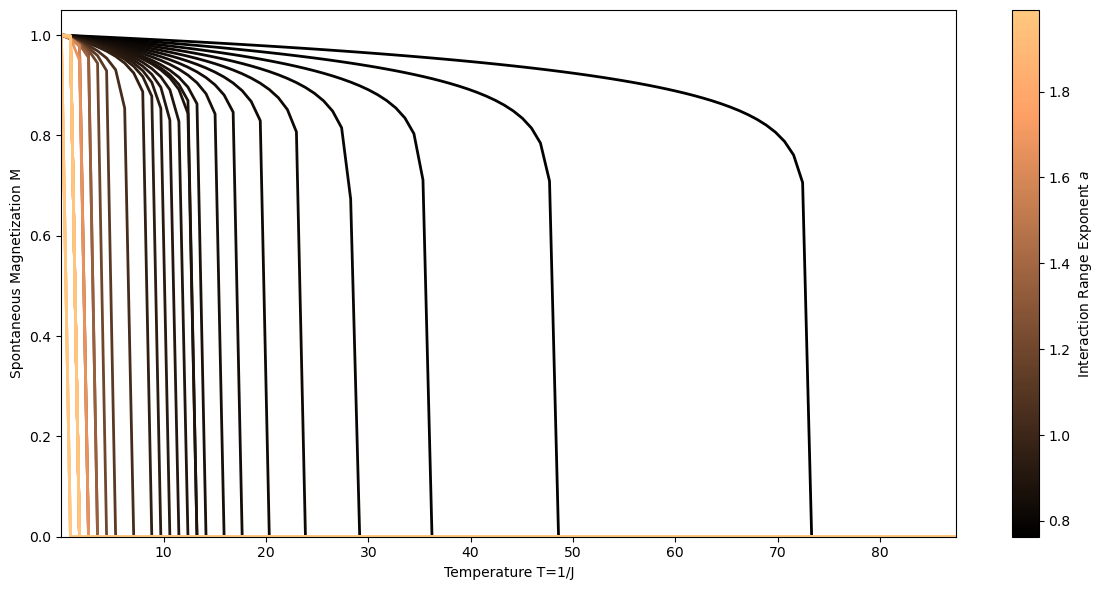

In [100]:
import matplotlib.cm as cm

# Compute T_c and beta for each n
Tcs = 1 / Jcs
betas = etas * nus  # beta = eta * nu = (1 - y_H) / y_T

# Set up temperature range
num_T = 100
T_min = 0.01
T_max = np.max(Tcs) * 1.2  # Slightly above max Tc
T_values = np.linspace(T_min, T_max, num_T)

# Compute M for each n
M_values = np.zeros((num_T, len(n_values)))
for i, (Tc_i, beta_i) in enumerate(zip(Tcs, betas)):
    for j, T in enumerate(T_values):
        if T < Tc_i:
            M_values[j, i] = (1 - T / Tc_i) ** beta_i
        else:
            M_values[j, i] = 0  # M = 0 for T >= Tc

# Create 2D plot with multiple curves using colormap
fig, ax = plt.subplots(figsize=(12, 6))
cmap = cm.copper # Colormap
norm = plt.Normalize(min(n_values), max(n_values))  # Normalize n to colormap range

for i, n_i in enumerate(n_values):
    ax.plot(T_values, M_values[:, i], linewidth=2, color=cmap(norm(n_i)))

# Add colorbar to indicate n values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax, label='Interaction Range Exponent $a$')

ax.set_xlabel('Temperature T=1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_ylim(0, 1.05)
ax.set_xlim(T_min, T_max)
ax.grid(False)
plt.tight_layout()
plt.savefig(f'../figures/magnetization_all_n.png')
plt.show()

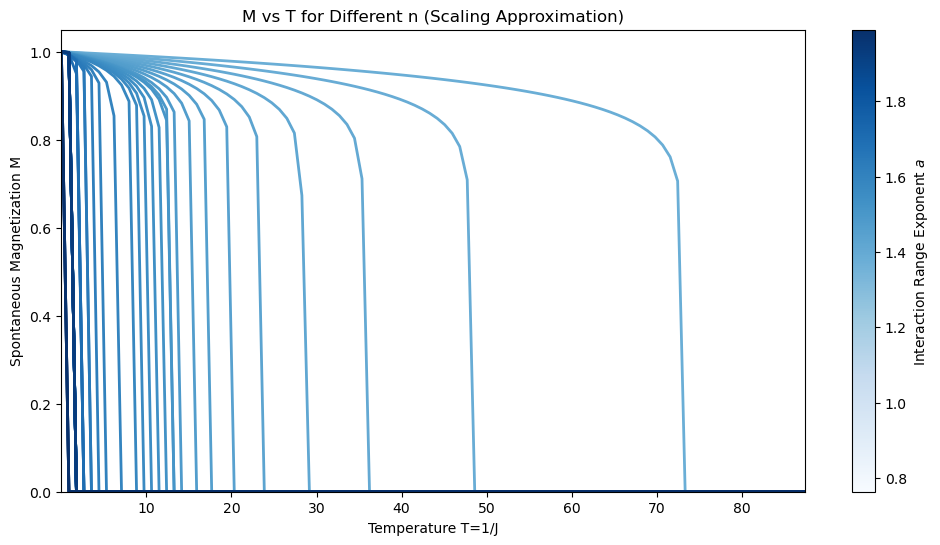

In [93]:
from matplotlib.colors import Normalize

# Create 2D plot with multiple curves using clipped Blues colormap
fig, ax = plt.subplots(figsize=(12, 6))
cmap = cm.Blues  # Colormap
# Normalize n values to map to [0.3, 1.0] of Blues to avoid very light colors
norm = Normalize(vmin=min(n_values), vmax=max(n_values))
cmap_range = np.linspace(0.5, 1.0, len(n_values))  # Use only 0.3 to 1.0 of colormap

for i, n_i in enumerate(n_values):
    # Map n_i to the clipped colormap range
    color = cmap(cmap_range[i])
    ax.plot(T_values, M_values[:, i], linewidth=2, color=color)

# Add colorbar to indicate n values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax, label='Interaction Range Exponent $a$')

ax.set_xlabel('Temperature T=1/J')
ax.set_ylabel('Spontaneous Magnetization M')
ax.set_title('M vs T for Different n (Scaling Approximation)')
ax.set_ylim(0, 1.05)
ax.set_xlim(T_min, T_max)
ax.grid(False)
plt.show()

In [16]:
# ==============================================================
#  magnetization_long_range_aferro.py
#  ------------------------------------------------------------
#  Full RG calculation of the magnetisation for the
#  1-D long-range antiferromagnetic Ising model
#  J(r) = -|J0|/r^n   (J0>0)
#  using the 3-spin cell of the attached file.
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp, mpf, log, exp, power, inf, ninf

mp.dps = 40                     # high precision is essential for the logs

def mp_logsumexp(values):
    if not values:
        return mp.ninf
    max_val = max(values)
    sum_exp = mp.mpf(0)
    for v in values:
        sum_exp += mp.exp(v - max_val)
    return max_val + mp.log(sum_exp)
    
# ----------------------------------------------------------------------
#  Spin configurations of a 3-spin cell (plus = +1, minus = -1)
# ----------------------------------------------------------------------
plus_configs = [
    ([1, 1, 1], lambda J2, J4: 2*J2 + J4),
    ([1, 1,-1], lambda J2, J4: -J4),
    ([1,-1, 1], lambda J2, J4: -2*J2 + J4),
    ([-1,1, 1], lambda J2, J4: -J4)
]

minus_configs = [
    ([-1,-1,-1], lambda J2, J4: 2*J2 + J4),
    ([-1,-1, 1], lambda J2, J4: -J4),
    ([-1, 1,-1], lambda J2, J4: -2*J2 + J4),
    ([ 1,-1,-1], lambda J2, J4: -J4)
]

# ----------------------------------------------------------------------
#  Interaction J(r) = sign*J0 / r^n   (sign = -1 for antiferro)
# ----------------------------------------------------------------------
def get_J(d, J0, n, sign=-1):
    if d <= 0:
        return mpf(0)
    return mpf(sign * J0) / power(mpf(d), mpf(n))

# ----------------------------------------------------------------------
#  One RG step for a *single* inter-cell distance r
#  Returns (J', H')
# ----------------------------------------------------------------------
def rg_step_one_distance(start, J_func, H):
    """
    start : position of the first spin of the right cell
    J_func(d) : interaction at distance d (mpf)
    H : external field (mpf)
    """
    J2 = J_func(2)
    J4 = J_func(4)

    left_pos  = [1, 3, 5]
    right_pos = [start, start+2, start+4]

    distances = [(iL, iR, abs(right_pos[iR] - left_pos[iL]))
                 for iL in range(3) for iR in range(3)]

    def collect(is_pp):
        confsR = plus_configs if is_pp else minus_configs
        totals = []
        for spinsL, El_func in plus_configs:
            El = El_func(J2, J4)
            for spinsR, Er_func in confsR:
                Er = Er_func(J2, J4)
                Eint = mpf(0)
                for iL, iR, d in distances:
                    Eint += mpf(spinsL[iL] * spinsR[iR]) * J_func(d)
                # ---- magnetic field on the 6 spins ----
                Hcontrib = H * (sum(spinsL) + sum(spinsR))
                totals.append(El + Er + Eint + Hcontrib)
        return totals

    pp = collect(True)
    pm = collect(False)

    logR_pp = mp_logsumexp(pp)
    logR_pm = mp_logsumexp(pm)

    # J'  (Eq.5 of the paper)
    Jp = mpf('0.5') * (logR_pp - logR_pm) if logR_pm != ninf else inf

    # H'  (Eq.5 of the paper, the 1-1 term)
    # R1(s0,s1) = sum over configs with cell-spins s0,s1
    # we reuse the already computed pp/pm lists:
    #   pp : both cells +1
    #   pm : left +1, right -1   (the opposite is never needed for H')
    logR1_pp = mp_logsumexp(pp)                # both cells +1
    logR1_mm = mp_logsumexp([t for t in pm])   # both cells -1  (same energies as pm)
    Hp = mpf('0.25') * (logR1_pp - logR1_mm) if logR1_mm != ninf else inf

    return Jp, Hp

# ----------------------------------------------------------------------
#  Full RG flow for a *set* of distances (max_r)
#  Returns list of J-vectors, list of H, list of R-matrices
# ----------------------------------------------------------------------
def rg_flow(J0, n, H0, max_r=6, max_steps=30, eps=1e-12):
    """
    J0   >0   (antiferromagnetic strength)
    n    exponent
    H0   external field
    max_r  number of J(r) that are kept (r=1…max_r)
    """
    # ----- initial interactions (all distances) -----
    J_dict = {r: get_J(r, J0, n, sign=-1) for r in range(1, max_r+1)}
    H = mpf(H0)

    J_history = []          # list of dicts {r: J(r)}
    H_history = [float(H)]
    R_history = []          # recursion matrices (numpy)

    for step in range(max_steps):
        J_history.append(J_dict.copy())

        # ---- compute recursion matrix R (linearised) ----
        # parameters = J(1)…J(max_r), H
        params = list(range(1, max_r+1)) + ['H']
        base = {}
        for r in range(1, max_r+1):
            start = 3*r + 1                     # distance r between cells
            base[r] = rg_step_one_distance(start, lambda d: J_dict.get(d, mpf(0)), H)[0]
        base['H'] = H

        R = np.zeros((len(params), len(params)), dtype=float)
        for i, p in enumerate(params):
            pert = J_dict.copy()
            if p == 'H':
                pert_H = H + mpf(eps)
            else:
                pert[p] = pert.get(p, mpf(0)) + mpf(eps)
                pert_H = H
            for j, r in enumerate(range(1, max_r+1)):
                start = 3*r + 1
                Jp = rg_step_one_distance(start,
                                          lambda d: pert.get(d, mpf(0)), pert_H)[0]
                R[j, i] = float((Jp - base[r]) / eps)
            # H' derivative
            Hp = rg_step_one_distance(start,
                                      lambda d: pert.get(d, mpf(0)), pert_H)[1]
            R[-1, i] = float((Hp - base['H']) / eps)
        R_history.append(R)

        # ---- apply one RG step (only the distances we keep) ----
        newJ = {}
        for r in range(1, max_r+1):
            start = 3*r + 1
            newJ[r], newH = rg_step_one_distance(start,
                                                lambda d: J_dict.get(d, mpf(0)), H)
            H = newH
        J_dict = newJ
        H_history.append(float(H))

        # ---- sink detection ----
        # antiferromagnetic sink: all |J(r)| → 0   (paramagnetic)
        # (in practice we look at the strongest remaining coupling)
        strongest = max(abs(float(v)) for v in J_dict.values())
        if strongest < 1e-9:
            sink = 'para'
            M_sink = 0.0
            break
        if step == max_steps-1:
            raise RuntimeError("RG did not converge to a sink")

    else:
        raise RuntimeError("Maximum RG steps exceeded")

    return J_history, H_history, R_history, sink, M_sink, step+1   # n_steps

# ----------------------------------------------------------------------
#  Back-propagation of the magnetisation
# ----------------------------------------------------------------------
def magnetisation(J0, n, H0, max_r=6):
    _, _, R_list, sink, M_sink, n_steps = rg_flow(J0, n, H0, max_r=max_r)

    # start from the sink
    M = np.array([M_sink])                     # 1-component vector

    b = 3.0
    d = 1.0
    for R in reversed(R_list):
        # R acts on the *full* parameter vector (J1…Jmax_r, H)
        # magnetisation lives in the H-direction → last row/column
        R_HH = R[-1, -1]                       # ∂H'/∂H
        M = (b**d) * R_HH * M                   # scalar version

    return float(M[0])

# ----------------------------------------------------------------------
#  Use-case: M vs temperature (1/J) for a fixed n
# ----------------------------------------------------------------------
def plot_magnetisation_vs_temperature(n=1.2, H0=0.01,
                                      J_values=np.linspace(0.1, 2.0, 30),
                                      max_r=6):
    """
    n        : power-law exponent
    H0       : external field (kept fixed)
    J_values : list of |J0|  (temperature = 1/|J0|)
    """
    temps = 1.0 / J_values
    mags  = []

    print(f"Computing magnetisation for n={n}, H={H0} …")
    for J0 in J_values:
        M = magnetisation(J0, n, H0, max_r=max_r)
        mags.append(M)
        print(f"  1/J = {1/J0:6.3f}  →  M = {M:8.5f}")

    plt.figure(figsize=(6,4.5))
    plt.plot(temps, mags, 'o-', color='steelblue')
    plt.xlabel(r'Temperature $1/|J|$')
    plt.ylabel('Magnetisation $M$')
    plt.title(f'1-D long-range antiferromagnetic Ising, $n={n}$')
    plt.grid(True, ls=':')
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------
#  Example run
# ----------------------------------------------------------------------
if __name__ == "__main__":
    # Choose a value inside the ferromagnetic window of the original paper
    # (the antiferro version has no ordered phase, but a tiny H forces a
    #  non-zero M that we can still compute)
    plot_magnetisation_vs_temperature(n=1.2, H0=0.005,
                                      J_values=np.linspace(0.3, 2.5, 25),
                                      max_r=6)

Computing magnetisation for n=1.2, H=0.005 …


RuntimeError: RG did not converge to a sink